Imports

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import joblib
from typing import Tuple
import warnings
from scipy import stats
from scipy.fft import fft
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading

In [36]:
# class DataLoader:
#     def __init__(self):
#         self.train_data = None
#         self.test_data = None
        
#     def load_data(self, root_dir: str) -> Tuple[pd.DataFrame, np.ndarray]:
#         data_frames = []
        
#         for folder in sorted(os.listdir(root_dir)):
#             folder_path = os.path.join(root_dir, folder)
#             if not os.path.isdir(folder_path):
#                 continue
                
#             for file in os.listdir(folder_path):
#                 if not file.endswith('.csv'):
#                     continue
                    
#                 file_path = os.path.join(folder_path, file)
#                 df = pd.read_csv(file_path, encoding="ISO-8859-1")
#                 df['label'] = folder
#                 data_frames.append(df)
        
#         combined = pd.concat(data_frames, ignore_index=True)
#         X = combined.drop(columns=['label'])
#         y = combined['label'].values
        
#         return X, y

# loader = DataLoader()
# X_train_raw, y_train_raw = loader.load_data('train')
# X_test_raw, y_test_raw = loader.load_data('test')

# print(f"Training Data Shape: {X_train_raw.shape}")
# print(f"Test Data Shape: {X_test_raw.shape}")
# print(f"Features: {X_train_raw.shape[1]}")
# print(f"Classes: {len(np.unique(y_train_raw))}")


Preprocessing

In [37]:
# class DataProcessor:
#     def __init__(self, random_state: int = 43):
#         self.random_state = random_state
#         self.scaler = StandardScaler()
#         self.label_encoder = LabelEncoder()
        
#     def clean_data(self, X: pd.DataFrame) -> pd.DataFrame:
#         cols_to_drop = ['Unnamed: 0', 'time']
#         X_clean = X.drop(columns=[col for col in cols_to_drop if col in X.columns], errors='ignore')
#         X_clean = X_clean.dropna()
#         return X_clean
    
#     def fit_transform_train(self, X_train: pd.DataFrame, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
#         X_clean = self.clean_data(X_train)
#         valid_indices = X_clean.index
#         X_values = X_clean.values
#         y_aligned = y_train[valid_indices]
        
#         shuffled_indices = shuffle(range(len(X_values)), random_state=self.random_state)
#         X_shuffled = X_values[shuffled_indices]
#         y_shuffled = y_aligned[shuffled_indices]
        
#         y_encoded = self.label_encoder.fit_transform(y_shuffled)
#         X_scaled = self.scaler.fit_transform(X_shuffled)
#         y_final = self.label_encoder.inverse_transform(y_encoded)
        
#         return X_scaled, y_final
    
#     def transform_test(self, X_test: pd.DataFrame, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
#         X_clean = self.clean_data(X_test)
#         valid_indices = X_clean.index
#         X_values = X_clean.values
#         y_aligned = y_test[valid_indices]
#         X_scaled = self.scaler.transform(X_values)
        
#         return X_scaled, y_aligned
        
# processor = DataProcessor()
# X_train_processed, y_train_processed = processor.fit_transform_train(X_train_raw, y_train_raw)
# X_test_processed, y_test_processed = processor.transform_test(X_test_raw, y_test_raw)

# print("Data Processing Summary:")
# print(f"Original Training Samples: {len(X_train_raw):,}")
# print(f"Processed Training Samples: {len(X_train_processed):,}")
# print(f"Test Samples: {len(X_test_processed):,}")


Data Loading and Preprocessing Updated

In [49]:
class DataLoader:
    def __init__(self, train_split=0.7, random_state=43):
        self.train_split = train_split
        self.random_state = random_state
        self.all_data = None
        self.all_labels = None
        self.worker_metadata = None
        self.train_workers = None
        self.test_workers = None

    def load_all_data(self, train_dir: str, test_dir: str) -> None:

        all_data_frames = []
        all_metadata = []

        for directory, dir_type in [(train_dir, 'original_train'), (test_dir, 'original_test')]:
            if not os.path.exists(directory):
                continue

            for folder in sorted(os.listdir(directory)):
                folder_path = os.path.join(directory, folder)
                if not os.path.isdir(folder_path):
                    continue

                for file in os.listdir(folder_path):
                    if not file.endswith('.csv'):
                        continue

                    file_path = os.path.join(folder_path, file)
                    df = pd.read_csv(file_path, encoding="ISO-8859-1")
                    worker_id = f"{dir_type}_{folder}_{file.replace('.csv', '')}"

                    for idx in range(len(df)):
                        all_metadata.append({
                            'worker_id': worker_id,
                            'activity': folder,
                            'original_source': dir_type,
                            'file_path': file_path,
                            'row_in_file': idx
                        })

                    df['label'] = folder
                    all_data_frames.append(df)

        self.all_data = pd.concat(all_data_frames, ignore_index=True)
        self.worker_metadata = pd.DataFrame(all_metadata)
        self.all_labels = self.all_data['label'].values

        print(f"Total samples: {len(self.all_data)}")
        print(f"Unique workers: {self.worker_metadata['worker_id'].nunique()}")
        print(f"Activities: {sorted(self.worker_metadata['activity'].unique())}")

        self._analyze_worker_distribution()

    def _analyze_worker_distribution(self):
        print("Worker distribution per activity:")
        for activity in sorted(self.worker_metadata['activity'].unique()):
            workers = self.worker_metadata[self.worker_metadata['activity'] == activity]['worker_id'].nunique()
            samples = len(self.worker_metadata[self.worker_metadata['activity'] == activity])
            print(f"{activity}: {workers} workers, {samples} samples")
        print(f"Total: {self.worker_metadata['worker_id'].nunique()} workers, {len(self.worker_metadata)} samples")

    def split_by_workers(self) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        if self.all_data is None:
            raise ValueError("Data not loaded.")

        all_workers = self.worker_metadata['worker_id'].unique()
        np.random.seed(self.random_state)
        np.random.shuffle(all_workers)

        n_train_workers = int(len(all_workers) * self.train_split)
        self.train_workers = all_workers[:n_train_workers]
        self.test_workers = all_workers[n_train_workers:]

        print(f"Train workers: {len(self.train_workers)}")
        print(f"Test workers: {len(self.test_workers)}")

        train_mask = self.worker_metadata['worker_id'].isin(self.train_workers)
        test_mask = self.worker_metadata['worker_id'].isin(self.test_workers)

        X_train = self.all_data[train_mask].drop(columns=['label']).reset_index(drop=True)
        X_test = self.all_data[test_mask].drop(columns=['label']).reset_index(drop=True)
        y_train = self.all_labels[train_mask]
        y_test = self.all_labels[test_mask]

        print(f"Train samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")

        self._check_activity_distribution(train_mask, test_mask)

        return X_train, X_test, y_train, y_test

    def _check_activity_distribution(self, train_mask, test_mask):
        train_activities = set(self.worker_metadata[train_mask]['activity'].unique())
        test_activities = set(self.worker_metadata[test_mask]['activity'].unique())
        all_activities = set(self.worker_metadata['activity'].unique())

        print(f"Train activities: {sorted(train_activities)}")
        print(f"Test activities: {sorted(test_activities)}")

        if all_activities - train_activities:
            print(f"Missing in train: {sorted(all_activities - train_activities)}")
        if all_activities - test_activities:
            print(f"Missing in test: {sorted(all_activities - test_activities)}")

    def load_data(self, root_dir: str) -> Tuple[pd.DataFrame, np.ndarray]:
        if root_dir.lower() == 'train':
            if self.all_data is None:
                raise ValueError("Call load_all_data first.")
            train_mask = self.worker_metadata['worker_id'].isin(self.train_workers)
            X = self.all_data[train_mask].drop(columns=['label']).reset_index(drop=True)
            y = self.all_labels[train_mask]
            return X, y
        elif root_dir.lower() == 'test':
            if self.all_data is None:
                raise ValueError("Call load_all_data first.")
            test_mask = self.worker_metadata['worker_id'].isin(self.test_workers)
            X = self.all_data[test_mask].drop(columns=['label']).reset_index(drop=True)
            y = self.all_labels[test_mask]
            return X, y
        else:
            raise ValueError("Invalid root_dir. Use 'train' or 'test'.")

    def get_train_test_split(self, train_dir: str = 'train', test_dir: str = 'test') -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        self.load_all_data(train_dir, test_dir)
        return self.split_by_workers()


class DataProcessor:
    def __init__(self, random_state: int = 43):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def clean_data(self, X: pd.DataFrame) -> pd.DataFrame:
        cols_to_drop = ['Unnamed: 0', 'time']
        X_clean = X.drop(columns=[col for col in cols_to_drop if col in X.columns], errors='ignore')
        return X_clean.dropna()

    def fit_transform_train(self, X_train: pd.DataFrame, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

        X_clean = self.clean_data(X_train)
        print(f"X_clean shape: {X_clean.shape}")

        valid_indices = X_clean.index.tolist()
        y_aligned = y_train if len(valid_indices) == len(y_train) else y_train[valid_indices]

        X_values = X_clean.values
        shuffled_indices = shuffle(range(len(X_values)), random_state=self.random_state)
        X_shuffled = X_values[shuffled_indices]
        y_shuffled = y_aligned[shuffled_indices]

        y_encoded = self.label_encoder.fit_transform(y_shuffled)
        X_scaled = self.scaler.fit_transform(X_shuffled)
        y_final = self.label_encoder.inverse_transform(y_encoded)

        print(f"X_scaled shape: {X_scaled.shape}, y_final shape: {y_final.shape}")
        return X_scaled, y_final

    def transform_test(self, X_test: pd.DataFrame, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        X_clean = self.clean_data(X_test)
        print(f"X_clean shape: {X_clean.shape}")

        valid_indices = X_clean.index.tolist()
        y_aligned = y_test if len(valid_indices) == len(y_test) else y_test[valid_indices]

        X_values = X_clean.values
        X_scaled = self.scaler.transform(X_values)

        print(f"X_scaled shape: {X_scaled.shape}, y_aligned shape: {y_aligned.shape}")
        return X_scaled, y_aligned

loader = DataLoader(train_split=0.7, random_state=43)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = loader.get_train_test_split('train', 'test')

print(f"X_train shape: {X_train_raw.shape}")
print(f"X_test shape: {X_test_raw.shape}")
print(f"Features: {X_train_raw.shape[1]}")
print(f"Classes: {len(np.unique(y_train_raw))}")

processor = DataProcessor()
X_train_processed, y_train_processed = processor.fit_transform_train(X_train_raw, y_train_raw)
X_test_processed, y_test_processed = processor.transform_test(X_test_raw, y_test_raw)

print(f"Processed X_train: {X_train_processed.shape}")
print(f"Processed X_test: {X_test_processed.shape}")


Total samples: 60625
Unique workers: 170
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']
Worker distribution per activity:
idle: 25 workers, 14240 samples
with_hook_climbing_up: 20 workers, 11889 samples
with_hook_descending_down: 23 workers, 11928 samples
without_hook_climbing_up: 51 workers, 11836 samples
without_hook_descending_down: 51 workers, 10732 samples
Total: 170 workers, 60625 samples
Train workers: 118
Test workers: 52
Train samples: 41973
Test samples: 18652
Train activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']
Test activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']
X_train shape: (41973, 12)
X_test shape: (18652, 12)
Features: 12
Classes: 5
X_train shape: (41973, 12), y_train shape: (41973,)
X_clean shape: (41973, 11)


Logistic Regression

In [50]:
model = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=1e-3,
    C=0.089,
    fit_intercept=True,
    intercept_scaling=0.80,
    class_weight=None,
    solver='liblinear',
    max_iter=100,
    multi_class='ovr',
    verbose=0,
    warm_start=False,
    n_jobs=-1,
    random_state=43
)

model.fit(X_train_processed, y_train_processed)


LogisticRegression(C=0.089, intercept_scaling=0.8, multi_class='ovr', n_jobs=-1,
                   random_state=43, solver='liblinear', tol=0.001)

Evaluation and Metrics

In [51]:
y_pred = model.predict(X_test_processed)
accuracy = accuracy_score(y_test_processed, y_pred)
cm = confusion_matrix(y_test_processed, y_pred)
classification_rep = classification_report(y_test_processed, y_pred, output_dict=True)

print("Model Performance Evaluation\n")
print(f"Test Accuracy: {accuracy:.6f}")
print(f"Test Samples: {len(y_test_processed):,}")

results_df = pd.DataFrame(classification_rep).transpose()
print("\nClassification Report:")
print(results_df.round(4))


Model Performance Evaluation

Test Accuracy: 0.877064
Test Samples: 18,652

Classification Report:
                              precision  recall  f1-score     support
idle                             0.9735  1.0000    0.9866   4806.0000
with_hook_climbing_up            0.7031  0.9240    0.7985   3393.0000
with_hook_descending_down        0.6811  0.5017    0.5778   2924.0000
without_hook_climbing_up         0.9567  0.8459    0.8979   3659.0000
without_hook_descending_down     0.9972  0.9964    0.9968   3870.0000
accuracy                         0.8771  0.8771    0.8771      0.8771
macro avg                        0.8623  0.8536    0.8515  18652.0000
weighted avg                     0.8801  0.8771    0.8730  18652.0000


Visualization

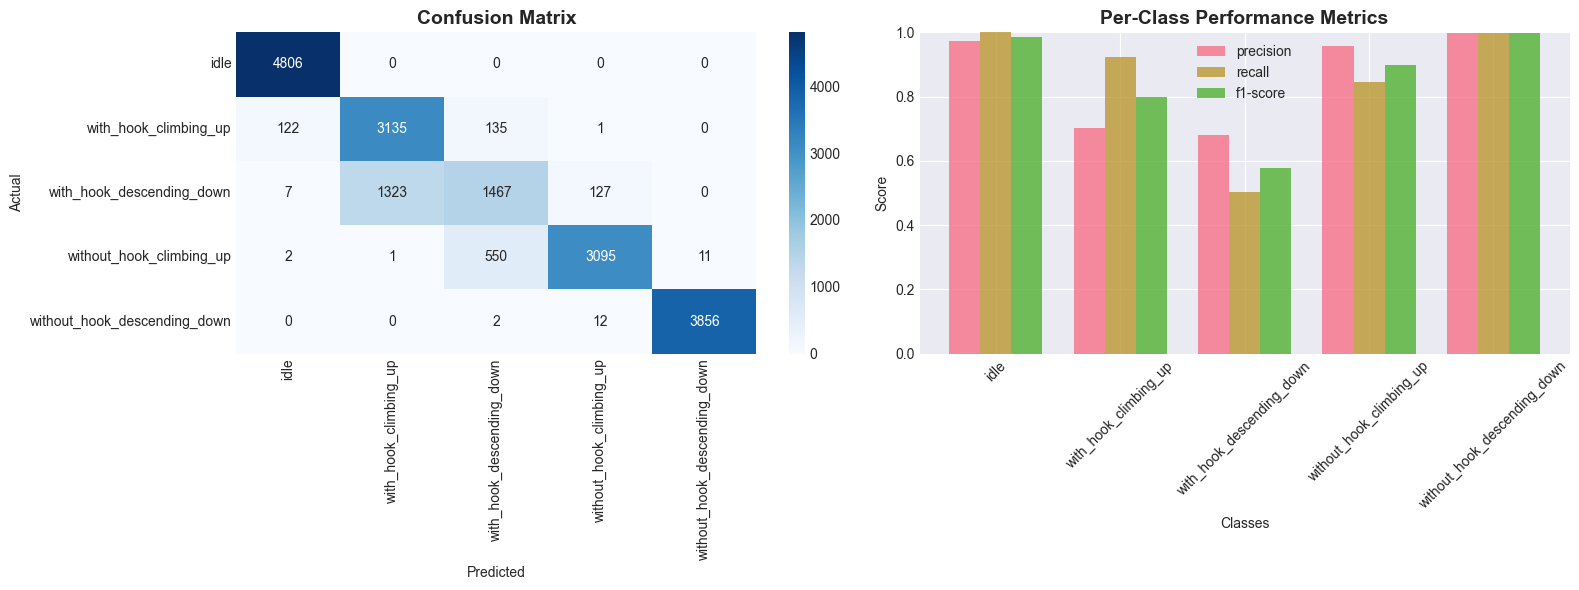

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_, ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Per-Class Performance Metrics
metrics = ['precision', 'recall', 'f1-score']
classes = [c for c in results_df.index if c not in ['accuracy', 'macro avg', 'weighted avg']]
x_pos = np.arange(len(classes))

for i, metric in enumerate(metrics):
    values = [results_df.loc[c, metric] for c in classes]
    ax2.bar(x_pos + i*0.25, values, width=0.25, label=metric, alpha=0.8)

ax2.set_xlabel('Classes')
ax2.set_ylabel('Score')
ax2.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos + 0.25)
ax2.set_xticklabels(classes, rotation=45)
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Saving Files

In [53]:
joblib.dump(model, "logistic_regression_model.pkl")
joblib.dump(processor.scaler, "scaler.pkl")
joblib.dump(processor.label_encoder, "label_encoder.pkl")

model_size_kb = os.path.getsize("logistic_regression_model.pkl") / 1024
print(f"\nModel Size: {model_size_kb:.2f} KB")



Model Size: 1.59 KB


Feature Extraction

In [54]:
def extract_statistical_features(X):
    features = np.column_stack([
        np.mean(X, axis=1), np.std(X, axis=1), np.var(X, axis=1),
        np.median(X, axis=1), np.min(X, axis=1), np.max(X, axis=1),
        np.percentile(X, 25, axis=1), np.percentile(X, 75, axis=1),
        stats.skew(X, axis=1), stats.kurtosis(X, axis=1)
    ])
    return features

def extract_frequency_features(X):
    fft_vals = np.abs(fft(X, axis=1))
    n_half = X.shape[1] // 2
    fft_vals = fft_vals[:, :n_half]
    
    features = np.column_stack([
        np.sum(fft_vals, axis=1), np.mean(fft_vals, axis=1),
        np.std(fft_vals, axis=1), np.max(fft_vals, axis=1)
    ])
    return features

def extract_temporal_features(X):
    zero_crossings = np.sum(np.diff(np.sign(X), axis=1) != 0, axis=1)
    first_diff = np.diff(X, axis=1)
    
    features = np.column_stack([
        zero_crossings,
        np.mean(first_diff, axis=1),
        np.std(first_diff, axis=1),
        np.sum(X**2, axis=1)
    ])
    return features

def extract_all_features(X):
    stat_features = extract_statistical_features(X)
    freq_features = extract_frequency_features(X)
    temp_features = extract_temporal_features(X)
    return np.column_stack([stat_features, freq_features, temp_features])

X_train_features = extract_all_features(X_train_processed)
X_test_features = extract_all_features(X_test_processed)

print(f"Training features extracted: {X_train_features.shape}")
print(f"Test features extracted: {X_test_features.shape}")

X_train_combined = np.column_stack([X_train_processed, X_train_features])
X_test_combined = np.column_stack([X_test_processed, X_test_features])

X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

original_feature_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p']
stat_feature_names = ['Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis']
freq_feature_names = ['FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max']
temp_feature_names = ['Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']

all_feature_names = original_feature_names + stat_feature_names + freq_feature_names + temp_feature_names

print(f"Training features: {X_train_combined.shape}")
print(f"Test features: {X_test_combined.shape}")
for i, name in enumerate(all_feature_names):
    print(f"{i:2d}: {name}")

Training features extracted: (41973, 18)
Test features extracted: (18652, 18)
Training features: (41973, 29)
Test features: (18652, 29)
 0: ax
 1: ay
 2: az
 3: gx
 4: gy
 5: gz
 6: mx
 7: my
 8: mz
 9: p
10: Mean
11: Std
12: Variance
13: Median
14: Min
15: Max
16: 25th Percentile
17: 75th Percentile
18: Skewness
19: Kurtosis
20: FFT Sum
21: FFT Mean
22: FFT Std
23: FFT Max
24: Zero Crossings
25: First Diff Mean
26: First Diff Std
27: Signal Energy


Feature Selection and Scaling

In [55]:
selector = SelectKBest(mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train_combined, y_train_processed)
X_test_selected = selector.transform(X_test_combined)

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_selected)
X_test_final = scaler.transform(X_test_selected)

Logistic Regression 

In [56]:
model_engineered = LogisticRegression(
    penalty='l1', dual=False, tol=1e-3, C=0.089, fit_intercept=True,
    intercept_scaling=0.80, solver='saga', max_iter=100,
    multi_class='multinomial', random_state=43, n_jobs=-1
)

model_engineered.fit(X_train_final, y_train_processed)

LogisticRegression(C=0.089, intercept_scaling=0.8, multi_class='multinomial',
                   n_jobs=-1, penalty='l1', random_state=43, solver='saga',
                   tol=0.001)

Evaluation and Metrics

In [57]:
y_pred_engineered = model_engineered.predict(X_test_final)
accuracy_engineered = accuracy_score(y_test_processed, y_pred_engineered)
cm_engineered = confusion_matrix(y_test_processed, y_pred_engineered)
classification_rep_engineered = classification_report(y_test_processed, y_pred_engineered, output_dict=True)

print("Engineered Features Model Performance")
print(f"Test Accuracy: {accuracy_engineered:.6f}")
print(f"Test Samples: {len(y_test_processed):,}")

results_df_engineered = pd.DataFrame(classification_rep_engineered).transpose()
print("\nClassification Report:")
print(results_df_engineered.round(4))

Engineered Features Model Performance
Test Accuracy: 0.995014
Test Samples: 18,652

Classification Report:
                              precision  recall  f1-score    support
idle                             0.9903  1.0000    0.9951   4806.000
with_hook_climbing_up            0.9988  0.9861    0.9924   3393.000
with_hook_descending_down        1.0000  0.9843    0.9921   2924.000
without_hook_climbing_up         0.9887  1.0000    0.9943   3659.000
without_hook_descending_down     1.0000  1.0000    1.0000   3870.000
accuracy                         0.9950  0.9950    0.9950      0.995
macro avg                        0.9956  0.9941    0.9948  18652.000
weighted avg                     0.9951  0.9950    0.9950  18652.000


Visualization

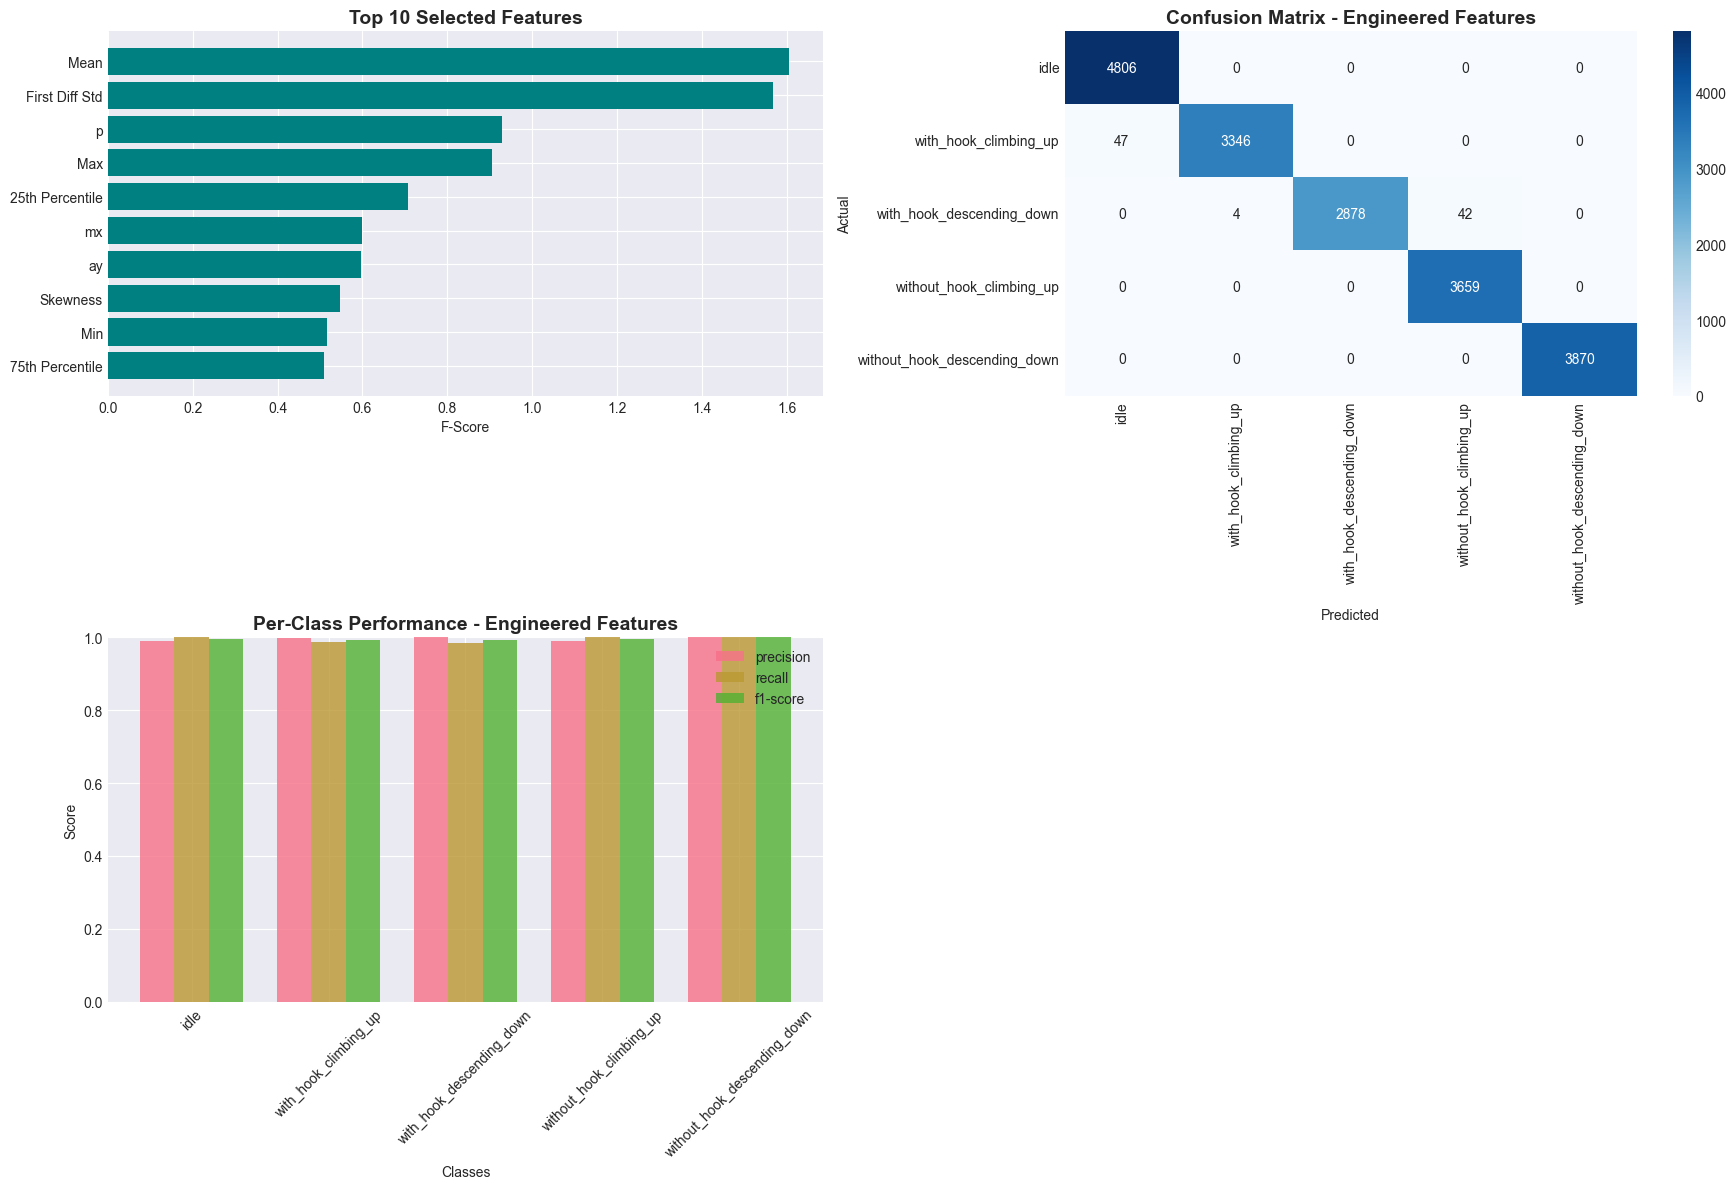

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 10 Selected Features
if hasattr(selector, 'scores_'):
    top_10_idx = np.argsort(selector.scores_)[-10:]
    top_10_scores = selector.scores_[top_10_idx]
    top_10_names = [all_feature_names[i] for i in top_10_idx]

    y_pos = np.arange(len(top_10_scores))
    axes[0, 0].barh(y_pos, top_10_scores, color='teal')
    axes[0, 0].set_yticks(y_pos)
    axes[0, 0].set_yticklabels(top_10_names)
    axes[0, 0].set_xlabel('F-Score')
    axes[0, 0].set_title('Top 10 Selected Features', fontsize=14, fontweight='bold')

# Confusion Matrix
sns.heatmap(cm_engineered, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_engineered.classes_,
            yticklabels=model_engineered.classes_,
            ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Engineered Features', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Per-Class Performance Bar Chart
metrics = ['precision', 'recall', 'f1-score']
classes = [c for c in results_df_engineered.index if c not in ['accuracy', 'macro avg', 'weighted avg']]
x_pos = np.arange(len(classes))

for i, metric in enumerate(metrics):
    values = [results_df_engineered.loc[c, metric] for c in classes]
    axes[1, 0].bar(x_pos + i*0.25, values, width=0.25, label=metric, alpha=0.8)

axes[1, 0].set_xlabel('Classes')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Per-Class Performance - Engineered Features', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos + 0.25)
axes[1, 0].set_xticklabels(classes, rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

Saving Engineered Model

In [59]:
joblib.dump(model_engineered, "engineered_lr_model.pkl")
model_size_kb = os.path.getsize("engineered_lr_model.pkl") / 1024

print(f"Engineered Model Size: {model_size_kb:.2f} KB")

Engineered Model Size: 1.51 KB
